### General libraries

In [4]:
import warnings
warnings.filterwarnings('ignore')

import os, glob
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

from sklearn import preprocessing, metrics
from sklearn.preprocessing import LabelEncoder
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split

# from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler

### Deep learning libraries

In [5]:
from tensorflow import keras
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout, Flatten, BatchNormalization, Conv2D, MaxPooling2D, SeparableConv2D, LeakyReLU
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adadelta, Adam
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

### Manipulate dictionary
This class to manipulate dictionary in order to it can be called like an object. For example: `data ['train']` to `data.train`.
**That is not required**. Just my initiative to make dictionary calls easier

In [6]:
class attrdict(dict):
    def __getattr__(self, name):
        return self[name]

    def __setattr__(self, name, value):
        self[name] = value

### General config

In [7]:
data_dir = 'data'
train_dir = os.path.join(data_dir, 'train')
test_dir = os.path.join(data_dir, 'test')
val_dir = os.path.join(data_dir, 'val')
model_dir = 'model'

width, height = 160, 160
resize = (width, height)
input_shape = (width, height, 1)
num_classes = 2

batch_size = 32
epochs = 10

### Load dataset

In [9]:
data = attrdict()
targetNames = ['NORMAL', 'PNEUMONIA']
train_test_dir = ['train', 'test', 'val']
data['NORMAL'], data['PNEUMONIA'] = [], []

le = LabelEncoder()

print("[STATUS] Load images directory")
for dir_path in glob.glob(os.path.join(data_dir, '*')):
    kind_dir = os.path.split(dir_path)[-1]
    if kind_dir in train_test_dir:
        data[kind_dir] = attrdict()
        data[kind_dir]['x'], data[kind_dir]['y'] = [], []

        for path in glob.glob(os.path.join(dir_path, '*')):
            label = os.path.split(path)[-1]

            images = glob.glob(os.path.join(path, '*.jpeg'))
            if len(images) != 0:
                for image in tqdm(images, desc='Load ' + path):
                    image = cv.imread(image, 0)
                    image = cv.resize(image, resize)
                    data[kind_dir]['x'].append(image)
                    data[kind_dir]['y'].append(label)
                    if label != 'val':
                        data[label].append(image)
        data[kind_dir]['x'] = np.array(data[kind_dir]['x'], dtype='f') / 255
        data[kind_dir]['x'] = data[kind_dir]['x'].reshape(data[kind_dir]['x'].shape[0], width, height, 1)
        data[kind_dir]['y'] = np.array(data[kind_dir]['y'])

        le.fit(data[kind_dir]['y'])
        data[kind_dir]['y'] = le.transform(data[kind_dir]['y'])

data.NORMAL = np.array(data.NORMAL)
data.PNEUMONIA = np.array(data.PNEUMONIA)

print("[STATUS] Load images completed")

Load data\test\NORMAL:   0%|                                                                   | 0/234 [00:00<?, ?it/s]

[STATUS] Load images directory


Load data\val\PNEUMONIA: 100%|███████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 20.38it/s]


[STATUS] Load images completed


### Show image dataset

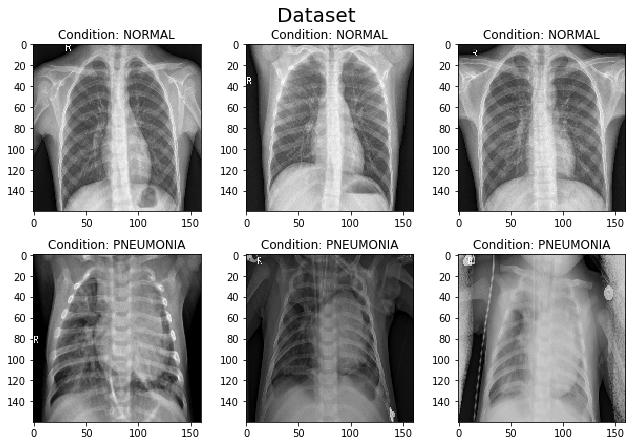

In [7]:
fig, ax = plt.subplots(2, 3, figsize=(9, 6))

k = 0
for j in range(len(ax[0])):
    ax[0][j].imshow(data.NORMAL[k].reshape(width, height), cmap='gray')
    ax[0][j].set_title('Condition: NORMAL')
    ax[1][j].imshow(data.PNEUMONIA[k].reshape(width, height), cmap='gray')
    ax[1][j].set_title('Condition: PNEUMONIA')
    k +=1

fig.suptitle('Dataset', position=(.5, 1.025), fontsize=20)
fig.tight_layout()
fig.show()

### Amount of image dataset before oversampling

In [8]:
print('target name : %s ' % targetNames)
for kind in data:
    try:
        print('%s : %s' % (kind, data[kind].x.shape))
    except:
        pass

print('NORMAL: %s,\nPNEUMONIA: %s' % (data.NORMAL.shape, data.PNEUMONIA.shape))

target name : ['NORMAL', 'PNEUMONIA'] 
test : (624, 160, 160, 1)
train : (5216, 160, 160, 1)
val : (16, 160, 160, 1)
NORMAL: (1583, 160, 160),
PNEUMONIA: (4273, 160, 160)


### Check the data distribution using TSNE

In [28]:
tsne = TSNE(n_components=2, init = 'pca', random_state=42)
X_TSNE = {}

for class_ in targetNames:
    X_TSNE[class_] = tsne.fit_transform(data[class_].reshape(data[class_].shape[0], width*height)).T

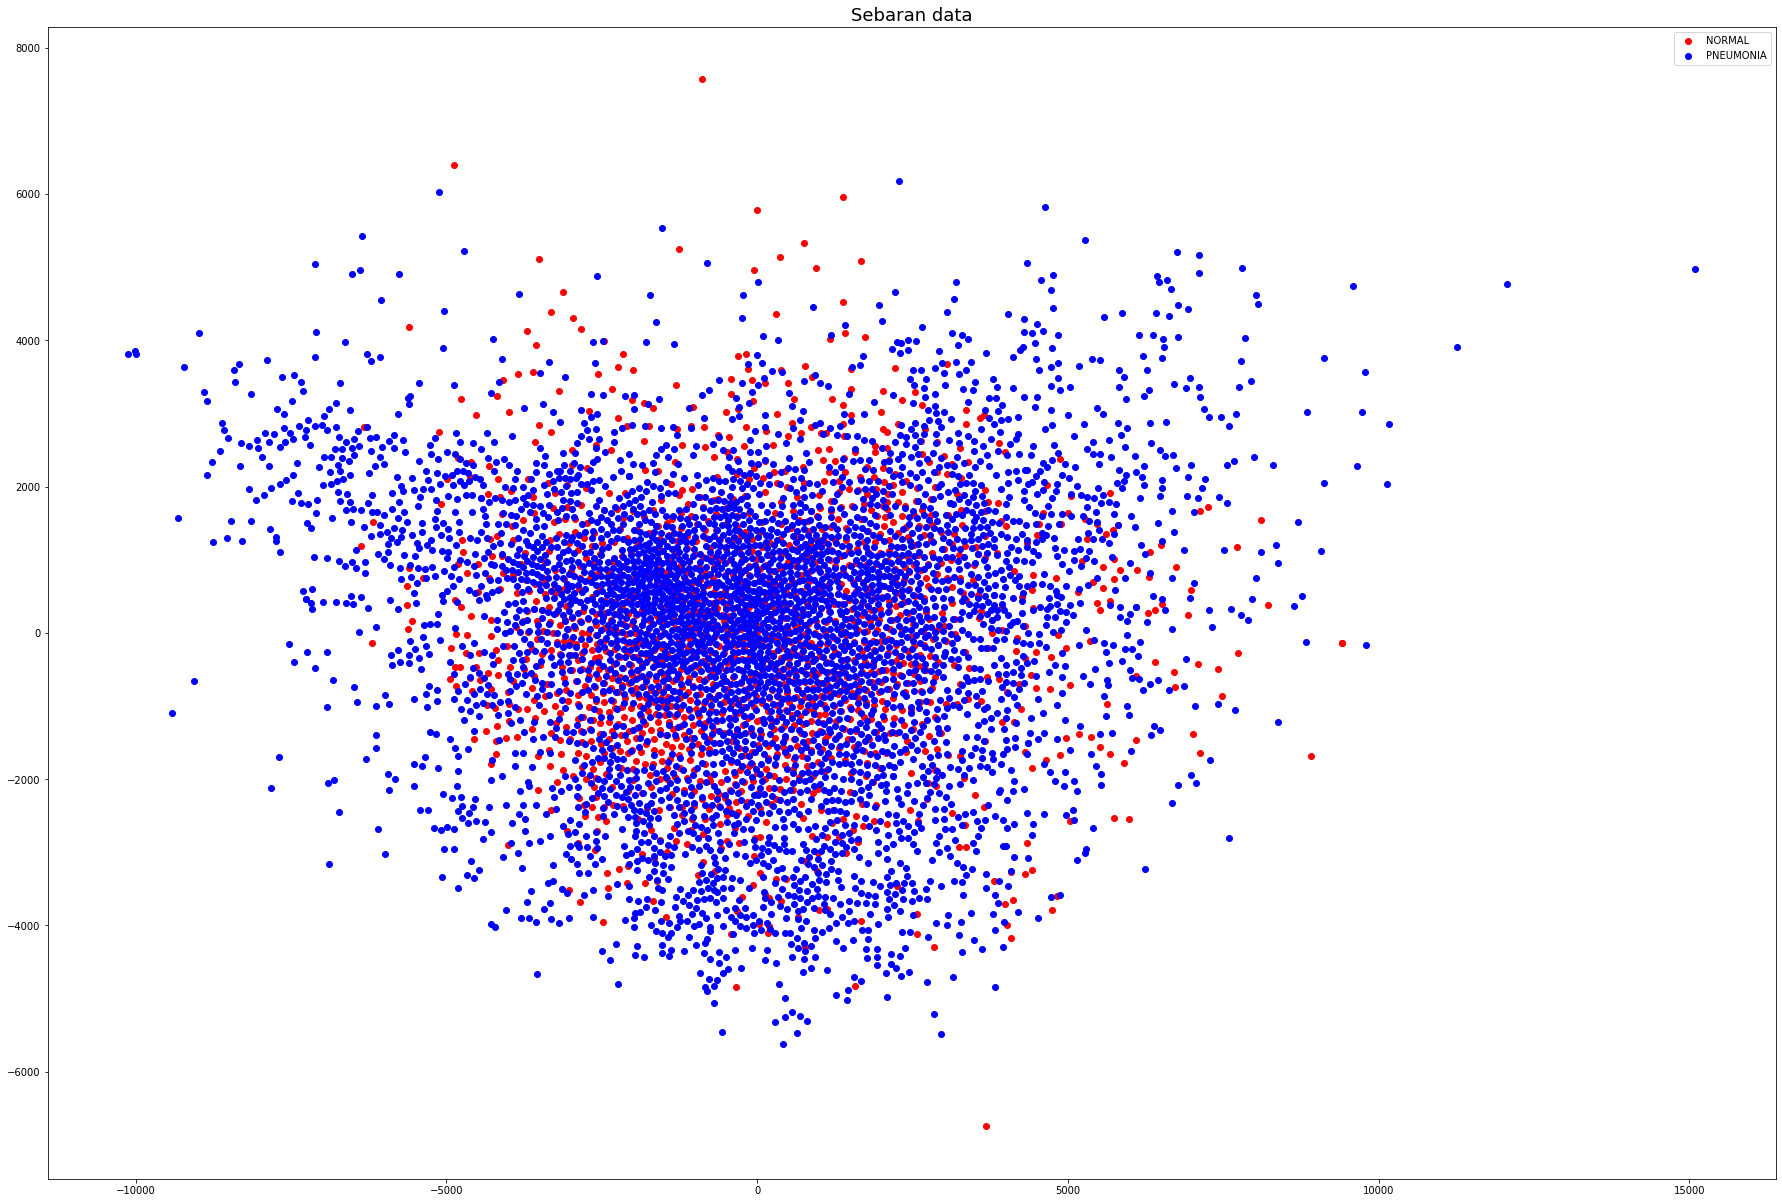

In [30]:
fig=plt.figure(figsize = (24, 16))
ax=fig.add_axes([0,0,1,1])
colors = ['r', 'b']

for color, class_ in zip(colors, X_TSNE):
    ax.scatter(X_TSNE[class_][0], X_TSNE[class_][1], color=color)

ax.legend(targetNames)
ax.set_title('Sebaran data', fontsize = 18)
plt.show()

### Join test data with training data

In [14]:
data.train.x = np.concatenate((data.train.x, data.test.x), axis=0)
data.train.y = np.concatenate((data.train.y, data.test.y), axis=0)

print('train :', data.train.x.shape)

train : (5840, 160, 160, 1)


### Random Over Sampling
The data applied for oversampling is the train data after it is joined with test data. After that previous test data  replaced with the result data from `train_test_split()`

In [15]:
over_sampling = RandomOverSampler(random_state=42)
x = data.train.x.reshape(data.train.x.shape[0], width*height)
data.train.x, data.train.y = over_sampling.fit_resample(x, data.train.y)
data.train.x = data.train.x.reshape(data.train.x.shape[0], width, height, 1)

In [16]:
data.train.x, data.test.x, data.train.y, data.test.y = \
train_test_split(data.train.x, data.train.y, test_size=0.10, random_state=42)

### Amount of image dataset after oversampling

In [17]:
print('target name : %s ' % targetNames)
for kind in data:
    try:
        print('%s : %s' % (kind, data[kind].x.shape))
    except:
        pass

target name : ['NORMAL', 'PNEUMONIA'] 
test : (853, 160, 160, 1)
train : (7677, 160, 160, 1)
val : (16, 160, 160, 1)


### Layer Structure Convolutional Neural Network

In [10]:
K.clear_session()
model = Sequential([
    Conv2D(16, kernel_size=(3, 3), activation='relu', padding='same', input_shape=input_shape),
    Conv2D(16, kernel_size=(3, 3), activation='relu', padding='same'),
    MaxPooling2D(pool_size=(2, 2)),

    SeparableConv2D(32, kernel_size=(3, 3), activation='relu', padding='same'),
    SeparableConv2D(32, kernel_size=(3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),

    SeparableConv2D(64, kernel_size=(3, 3), activation='relu', padding='same'),
    SeparableConv2D(64, kernel_size=(3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),

    SeparableConv2D(128, kernel_size=(3, 3), activation='relu', padding='same'),
    SeparableConv2D(128, kernel_size=(3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.2),

    SeparableConv2D(256, kernel_size=(3, 3), activation='relu', padding='same'),
    SeparableConv2D(256, kernel_size=(3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.2),

    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.7),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])
model.compile(optimizer = Adam(), loss='binary_crossentropy', metrics=['accuracy'])
checkpoint = ModelCheckpoint(filepath=os.path.join(model_dir, 'best_weights.hdf5'), save_best_only=True, save_weights_only=True)
lr_reduce = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=2, verbose=2, mode='max')
early_stop = EarlyStopping(monitor='val_loss', min_delta=0.1, patience=1, mode='min')

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 160, 160, 16)      160       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 160, 160, 16)      2320      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 80, 80, 16)        0         
_________________________________________________________________
separable_conv2d (SeparableC (None, 80, 80, 32)        688       
_________________________________________________________________
separable_conv2d_1 (Separabl (None, 80, 80, 32)        1344      
_________________________________________________________________
batch_normalization (BatchNo (None, 80, 80, 32)        128       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 40, 40, 32)        0

### Fitting the model

In [20]:
history = model.fit(data.train.x, data.train.y,
                    batch_size=batch_size, epochs=epochs, verbose=1,
                    validation_data=(data.test.x, data.test.y), callbacks=[checkpoint, lr_reduce])

score = model.evaluate(data.test.x, data.test.y, verbose=0)
print('\nEvaluate')
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Train on 7677 samples, validate on 853 samples
Epoch 1/10
7677/7677 [==============================] - 139s 18ms/sample - loss: 0.3134 - accuracy: 0.8679 - val_loss: 2.2144 - val_accuracy: 0.4713
Epoch 2/10
7677/7677 [==============================] - 106s 14ms/sample - loss: 0.1655 - accuracy: 0.9400 - val_loss: 2.8647 - val_accuracy: 0.4713
Epoch 3/10
7677/7677 [==============================] - 106s 14ms/sample - loss: 0.1314 - accuracy: 0.9538 - val_loss: 0.6489 - val_accuracy: 0.5428
Epoch 4/10
7648/7677 [============================>.] - ETA: 0s - loss: 0.1112 - accuracy: 0.9571
Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
7677/7677 [==============================] - 106s 14ms/sample - loss: 0.1115 - accuracy: 0.9569 - val_loss: 0.7293 - val_accuracy: 0.7140
Epoch 5/10
7677/7677 [==============================] - 107s 14ms/sample - loss: 0.0765 - accuracy: 0.9725 - val_loss: 0.0977 - val_accuracy: 0.9648
Epoch 6/10
7648/7677 [===================

In [35]:
pred = model.predict_classes(data.test.x)
print("Performance report (test): \n %s \n" %(metrics.classification_report(data.test.y, pred)))

Performance report (test): 
               precision    recall  f1-score   support

           0       0.97      0.99      0.98       451
           1       0.99      0.97      0.98       402

    accuracy                           0.98       853
   macro avg       0.98      0.98      0.98       853
weighted avg       0.98      0.98      0.98       853
 



### Plot history: Binary crossentropy & Accuracy

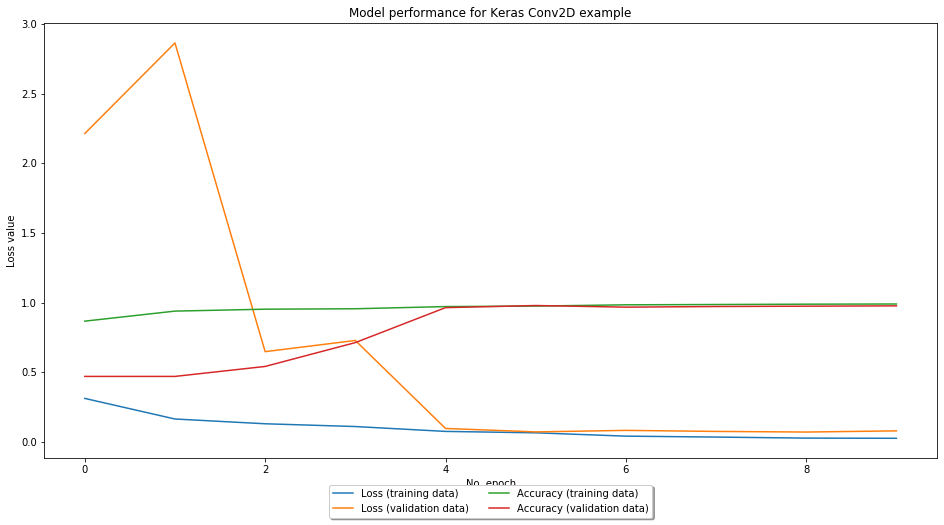

In [22]:
fig = plt.figure(figsize = (16, 8))
plt.plot(history.history['loss'], label='Loss (training data)')
plt.plot(history.history['val_loss'], label='Loss (validation data)')
plt.plot(history.history['accuracy'], label='Accuracy (training data)')
plt.plot(history.history['val_accuracy'], label='Accuracy (validation data)')
plt.title('Model performance for Keras Conv2D example')
plt.ylabel('Loss value')
plt.xlabel('No. epoch')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), shadow=True, ncol=2)
plt.show()

### Save the model

In [25]:
model.save(os.path.join(model_dir, 'pneumonia_classification_model2.hdf5'))

### Validate the model

In [23]:
predictions = model.predict_classes(data.val.x).flatten()

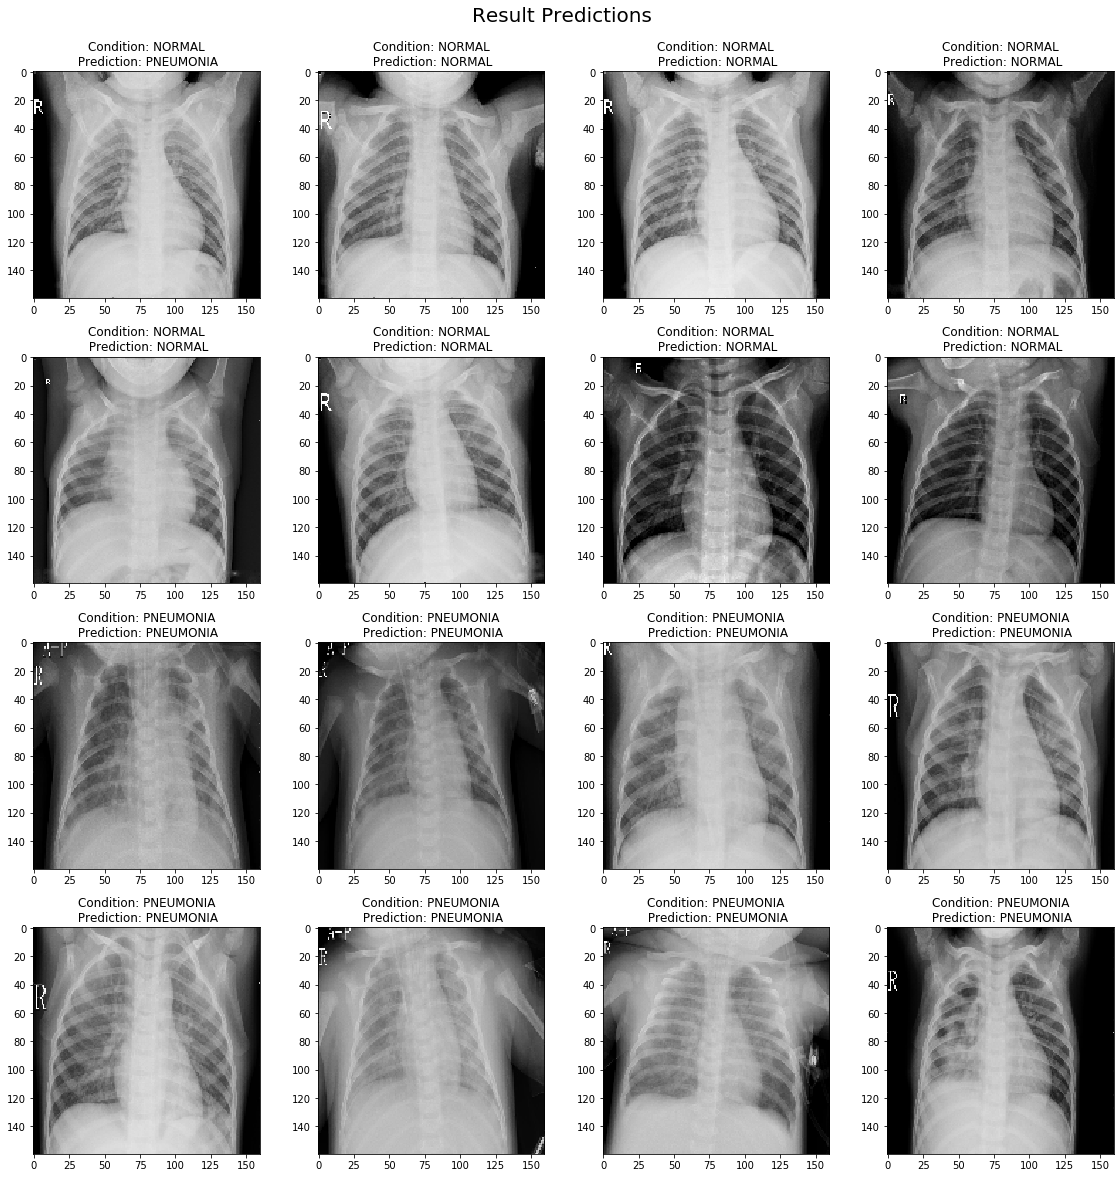

In [24]:
fig, ax = plt.subplots(4, 4, figsize=(16,16))
k = 0
for j in range(len(ax)):
    for i in range(len(ax[j])):
        ax[j][i].imshow(data.val.x[k].reshape(width, height), cmap='gray')
        ax[j][i].set_title('Condition: %s\n Prediction: %s' % (targetNames[data.val.y[k]], targetNames[predictions[k]]))
        k +=1

fig.suptitle('Result Predictions', position=(.5, 1.02), fontsize=20)
fig.tight_layout()
fig.show()